In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras import models
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Activation, Concatenate
from keras.layers import ReLU, LeakyReLU, BatchNormalization, Dropout
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.initializers import RandomNormal

from IPython import display
from PIL import Image
import time

2024-05-14 03:58:39.768708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 03:58:39.768899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 03:58:39.980761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# data_dir = "../input/wikiart/Realism"
data_dir = "../input/data-art/data_train"
input_dir = "/kaggle/working/datatrain"
output_dir = "/kaggle/working/Output"

In [3]:
# Preview image Frame
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 4

# Image parameters
SEED_SIZE = 100
IMG_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 10
LAMBDA = 100
SAVE_FREQ = 5

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [4]:
# preprocess images
def preprocess_image(img, to_gray=False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if to_gray:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = np.stack((img,)*3, axis=-1)  # Convert back to 3 channels
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 127.5 - 1  # Normalize to [-1, 1]
    return img

In [5]:
# load and preprocess images
def load_and_preprocess_images(image_dir):
    color_images = []
    gray_images = []
    for filename in tqdm(sorted(os.listdir(image_dir))):
        img_path = os.path.join(image_dir, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            color_img = preprocess_image(img, to_gray=False)
            gray_img = preprocess_image(img, to_gray=True)
            color_images.append(color_img)
            gray_images.append(gray_img)
    return np.array(gray_images), np.array(color_images)

In [6]:
# Downsample and Upsample blocks
def downsample(filters, size, apply_batchnorm=True):
    initializer = RandomNormal(0., 0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

In [7]:
def upsample(filters, size, apply_dropout=False):
    initializer = RandomNormal(0., 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

In [8]:
# Discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = Input(shape=[IMG_SIZE, IMG_SIZE, 3], name='input_image')
    tar = Input(shape=[IMG_SIZE, IMG_SIZE, 3], name='target_image')
    x = Concatenate()([inp, tar])
    
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    
    return Model(inputs=[inp, tar], outputs=last)

In [9]:
# Generator
def Generator():
    inputs = Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = RandomNormal(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # (bs, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [23]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [11]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [12]:
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator output
        gen_output = generator(input_image, training=True)

        # Discriminator output
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        # Generator loss
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)

        # Discriminator loss
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate gradients
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [25]:
# Training loop
def fit(train_ds, epochs):
    for epoch in range(epochs):        
        for input_image, target in train_ds:
            t = train_step(input_image, target, epoch)
            
            gen_total_loss_list.append(t[0])
            gen_gan_loss_list.append(t[1])
            gen_l1_loss_list.append(t[2])
            disc_loss_list.append(t[3])
            
        gen_total_loss_epoch = sum(gen_total_loss_list) / len(gen_total_loss_list)
        gen_gan_loss_epoch = sum(gen_gan_loss_list) / len(gen_gan_loss_list)
        gen_l1_loss_epoch = sum(gen_l1_loss_list) / len(gen_l1_loss_list)
        disc_loss_epoch = sum(disc_loss_list) / len(disc_loss_list)

        # Print losses for each epoch
        print(f'Epoch {epoch + 1}, '
              f'Gen Total Loss: {gen_total_loss_epoch}, '
              f'Gen GAN Loss: {gen_gan_loss_epoch}, '
              f'Gen L1 Loss: {gen_l1_loss_epoch}, '
              f'Disc Loss: {disc_loss_epoch}')

#         # Save generated images
#         for example_input, example_target in train_ds.take(1):
#             generate_images(generator, example_input, example_target)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))

        # Save checkpoint and images every save_every_n_epochs epochs
        if (epoch + 1) % SAVE_FREQ == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            save_images(generator, example_gray, example_color, epoch + 1, save_dir)

In [14]:
# Function to save images
def save_images(model, test_input, tar, epoch, output_dir):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the range [0, 1] to [0, 255] to visualize better
        plt.imshow((display_list[i] * 0.5 + 0.5) * 255.0)
        plt.axis('off')
    plt.savefig(os.path.join(output_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.close()

In [15]:
# Generate and save images
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5 + 0.5))
        plt.axis('off')
    plt.show()

In [16]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
gray_images, color_images = load_and_preprocess_images(data_dir)

# Create TensorFlow datasets
dataset = tf.data.Dataset.from_tensor_slices((gray_images, color_images)).batch(BATCH_SIZE)

100%|██████████| 539/539 [00:23<00:00, 22.89it/s]


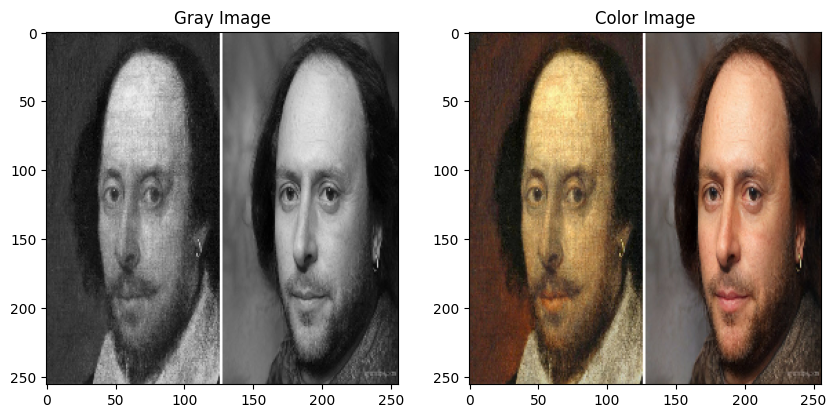

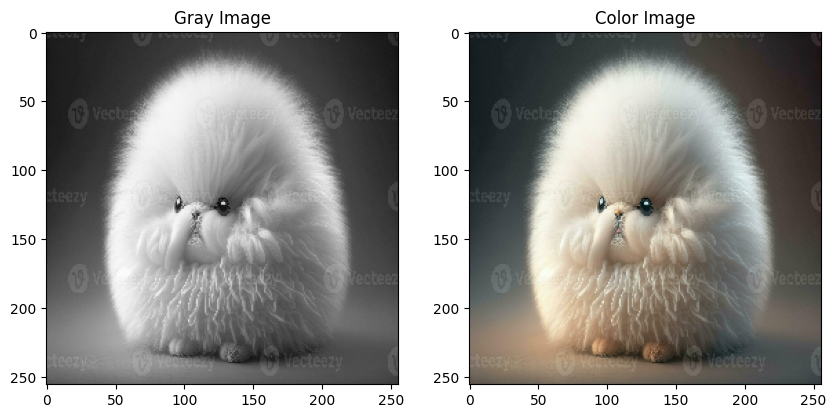

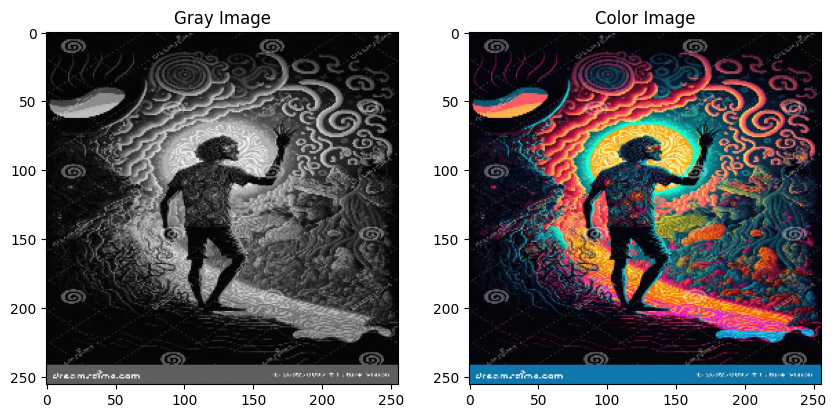

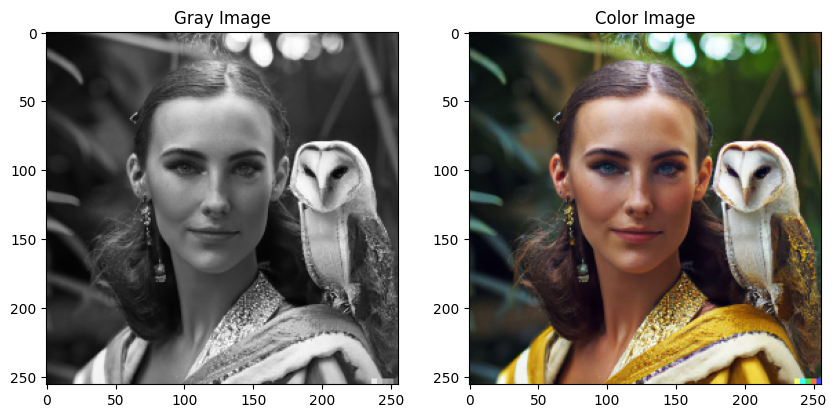

In [18]:
# Plot some examples
example_gray, example_color = next(iter(dataset))
def plot_images(gray_images, color_images, num_images=4):
    for i in range(num_images):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Gray Image')
        plt.imshow((gray_images[i] * 0.5 + 0.5).numpy().astype(np.float32))  # De-normalize and display
        plt.subplot(1, 2, 2)
        plt.title('Color Image')
        plt.imshow((color_images[i] * 0.5 + 0.5).numpy().astype(np.float32))  # De-normalize and display
        plt.show()

plot_images(example_gray, example_color)

In [19]:
generator = Generator()
generator.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [20]:
discriminator = Discriminator()
discriminator.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 128, 128,  │      6,144 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 64, 64,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 32, 32,    │    525,312 │ sequential_16[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_17[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_11[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [21]:
# Directory for storing checkpoints
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Define the checkpoint
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
gen_total_loss_list = []
gen_gan_loss_list = []
gen_l1_loss_list = []
disc_loss_list = []

fit(dataset, EPOCHS)